In [21]:
# Step 1: Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sns.set(style="whitegrid", palette="muted")

# Step 2: Load dataset

df = pd.read_csv(r"C:\Users\keert\OneDrive\Desktop\dbit\Mufg-AIML\manufacturing_dataset_1000_samples.csv")

print("Shape:", df.shape)
display(df.head())

Shape: (1000, 19)


,Timestamp,Injection_Temperature,Injection_Pressure,Cycle_Time,Cooling_Time,Material_Viscosity,Ambient_Temperature,Machine_Age,Operator_Experience,Maintenance_Hours,Shift,Machine_Type,Material_Grade,Day_of_Week,Temperature_Pressure_Ratio,Total_Cycle_Time,Efficiency_Score,Machine_Utilization,Parts_Per_Hour
0,2023-01-01 00:00:00,221.0,136.0,28.7,13.6,375.5,28.0,3.8,11.2,64,Evening,Type_B,Economy,Thursday,1.625,42.3,0.063,0.510,36.5
1,2023-01-01 01:00:00,213.3,128.9,34.5,14.0,215.8,22.6,6.8,6.3,58,Night,Type_A,Standard,Wednesday,1.655,48.5,0.037,0.389,29.9
2,2023-01-01 02:00:00,222.8,115.9,19.9,9.5,307.0,25.3,4.2,9.6,47,Day,Type_A,Standard,Monday,1.922,29.4,0.061,0.551,56.9
3,2023-01-01 03:00:00,233.3,105.3,39.2,13.1,137.8,26.0,9.2,8.6,49,Evening,Type_A,Premium,Saturday,2.215,52.3,0.054,0.293,31.0
4,2023-01-01 04:00:00,212.2,125.5,45.0,9.9,298.2,23.6,6.2,23.0,49,Night,Type_B,Premium,Monday,1.691,54.9,0.145,0.443,15.0


In [23]:
# Step 3: Feature engineering (Timestamp → Hour/Day/Month)

df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month

df.drop(columns=['Timestamp'], inplace=True)

print("New columns added: Hour, Day, Month")
display(df.head())

New columns added: Hour, Day, Month


,Injection_Temperature,Injection_Pressure,Cycle_Time,Cooling_Time,Material_Viscosity,Ambient_Temperature,Machine_Age,Operator_Experience,Maintenance_Hours,Shift,...,Material_Grade,Day_of_Week,Temperature_Pressure_Ratio,Total_Cycle_Time,Efficiency_Score,Machine_Utilization,Parts_Per_Hour,Hour,Day,Month
0,221.0,136.0,28.7,13.6,375.5,28.0,3.8,11.2,64,Evening,...,Economy,Thursday,1.625,42.3,0.063,0.510,36.5,0,1,1
1,213.3,128.9,34.5,14.0,215.8,22.6,6.8,6.3,58,Night,...,Standard,Wednesday,1.655,48.5,0.037,0.389,29.9,1,1,1
2,222.8,115.9,19.9,9.5,307.0,25.3,4.2,9.6,47,Day,...,Standard,Monday,1.922,29.4,0.061,0.551,56.9,2,1,1
3,233.3,105.3,39.2,13.1,137.8,26.0,9.2,8.6,49,Evening,...,Premium,Saturday,2.215,52.3,0.054,0.293,31.0,3,1,1
4,212.2,125.5,45.0,9.9,298.2,23.6,6.2,23.0,49,Night,...,Premium,Monday,1.691,54.9,0.145,0.443,15.0,4,1,1


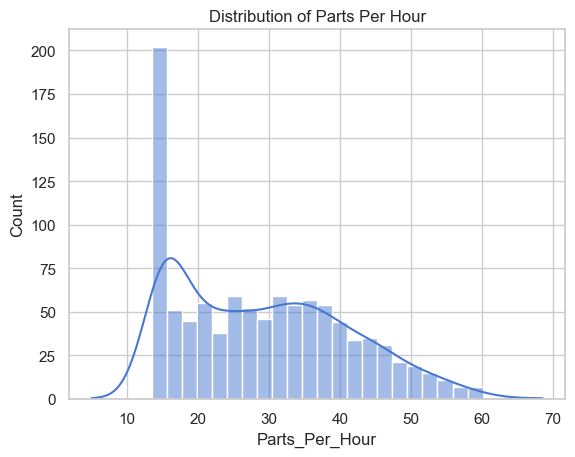

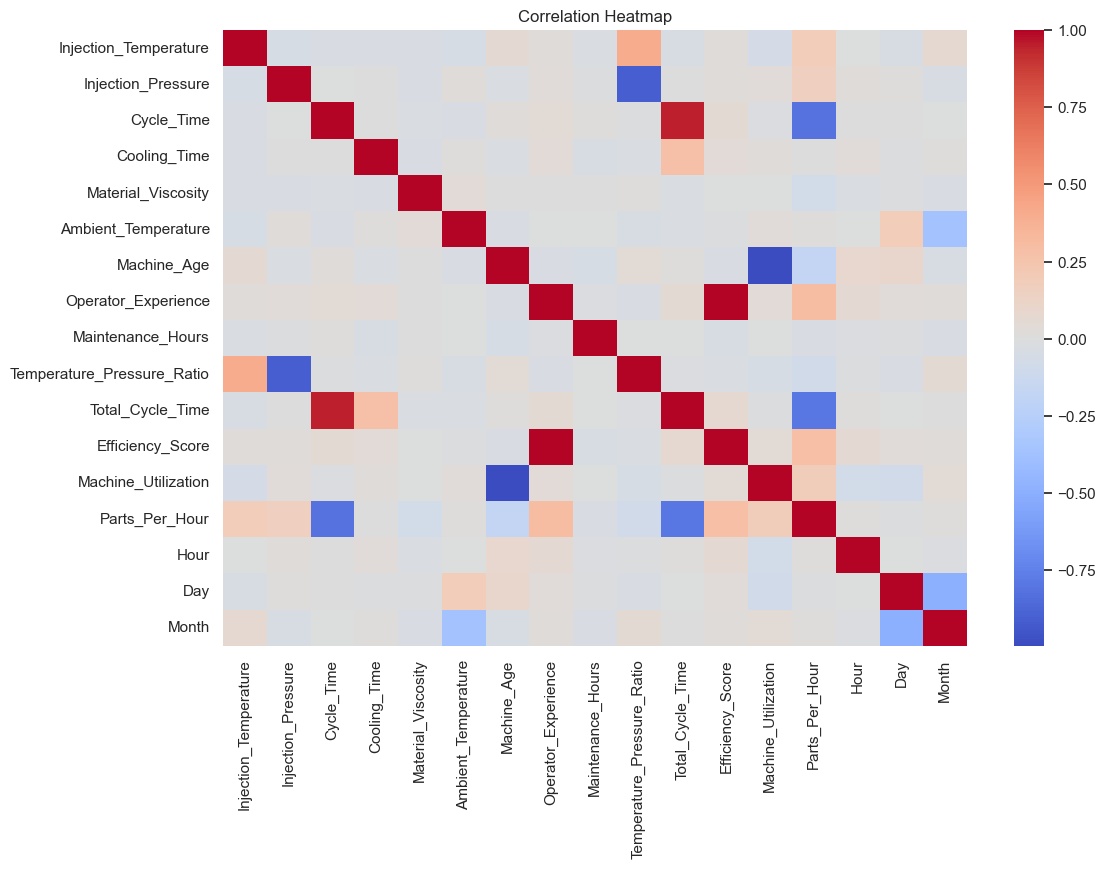

In [25]:
# Step 4: Exploratory Data Analysis (EDA)

# Target distribution
sns.histplot(df['Parts_Per_Hour'], kde=True, bins=30)
plt.title("Distribution of Parts Per Hour")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

In [27]:
# Step 5: Define Features & Target

target = "Parts_Per_Hour"
X = df.drop(columns=[target])
y = df[target]

categorical_features = ['Shift', 'Machine_Type', 'Material_Grade', 'Day_of_Week']
numerical_features = [col for col in X.columns if col not in categorical_features]

print("Categorical:", categorical_features)
print("Numerical:", numerical_features)

Categorical: ['Shift', 'Machine_Type', 'Material_Grade', 'Day_of_Week']
Numerical: ['Injection_Temperature', 'Injection_Pressure', 'Cycle_Time', 'Cooling_Time', 'Material_Viscosity', 'Ambient_Temperature', 'Machine_Age', 'Operator_Experience', 'Maintenance_Hours', 'Temperature_Pressure_Ratio', 'Total_Cycle_Time', 'Efficiency_Score', 'Machine_Utilization', 'Hour', 'Day', 'Month']


In [29]:
# Step 6: Preprocessing Pipelines

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),   # fill missing numeric
    ('scaler', StandardScaler())                     # scale
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # fill missing categorical
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # one-hot encode
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [31]:
# Step 7: Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (800, 20) Test shape: (200, 20)


In [36]:
# Step 8: Evaluation Function

def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Print regression metrics"""
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")
    print("-"*40)

In [38]:
# Step 9: Linear Regression

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)

print("Linear Regression Performance:")
evaluate_model(lr_pipeline, X_train, y_train, X_test, y_test)

Linear Regression Performance:
RMSE: 3.5103
MAE : 2.7277
R²  : 0.9056
----------------------------------------


In [40]:
# Step 10: Ridge Regression with GridSearchCV

ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

ridge_params = {'regressor__alpha': [0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(ridge_pipeline, ridge_params, cv=5,
                          scoring='neg_root_mean_squared_error')

ridge_grid.fit(X_train, y_train)

print("Ridge Best Params:", ridge_grid.best_params_)
print("Ridge Performance:")
evaluate_model(ridge_grid.best_estimator_, X_train, y_train, X_test, y_test)

Ridge Best Params: {'regressor__alpha': 0.01}
Ridge Performance:
RMSE: 3.5106
MAE : 2.7276
R²  : 0.9056
----------------------------------------


In [42]:
# Step 11: Lasso Regression with GridSearchCV

lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(max_iter=10000))
])

lasso_params = {'regressor__alpha': [0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(lasso_pipeline, lasso_params, cv=5,
                          scoring='neg_root_mean_squared_error')

lasso_grid.fit(X_train, y_train)

print("Lasso Best Params:", lasso_grid.best_params_)
print("Lasso Performance:")
evaluate_model(lasso_grid.best_estimator_, X_train, y_train, X_test, y_test)

Lasso Best Params: {'regressor__alpha': 0.01}
Lasso Performance:
RMSE: 3.4988
MAE : 2.7292
R²  : 0.9062
----------------------------------------


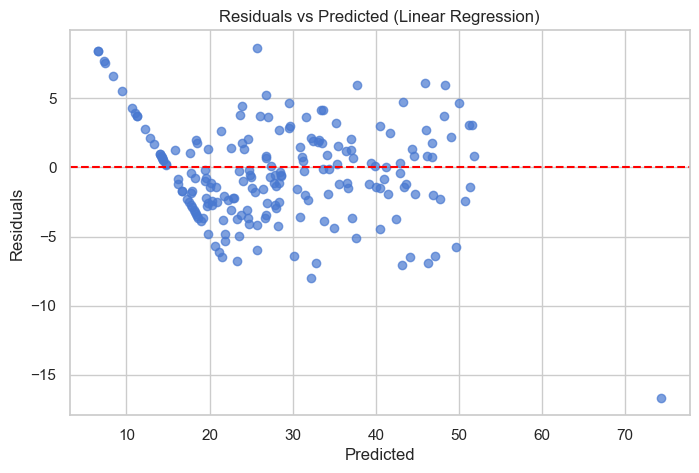

In [44]:
# Step 12: Residuals Plot (for Linear Regression)

y_pred = lr_pipeline.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Linear Regression)")
plt.show()